In [14]:
### Run this cell before continuing.
#library(cowplot)
library(dplyr)
library(gridExtra)
library(tidyverse)
library(repr)
library(infer)
library(repr)
library(datateachr)
library(digest)
library(lubridate)
library(taxyvr)
library(broom)
library(testthat)
    

*STAT 201 - GROUP 7*

# Comparing Vehicle Theft Rates in Vancouver, BC. 

Analysis by Soham Chakote, Lisa Desjarlais, Kiersten Lyde-Stad, Hongli Zhang

# Introduction

### Background

The rising level of crimes in Vancouver has raised serious concerns over the safety of Vancouverites. While the authorities are taking measures to improve the situation, residents can also take steps that ensure their safety and well-being. One of them includes avoiding areas with high crime rates. Most residents consider areas such as West End a lot safer than others such as Strathcona and Grandview-Woodland. Does the level of safety actually vary in different regions of Vancouver? We aim to find this out using methods of statistical inference. The Vancouver Police Department website has the data for crimes in Vancouver available for public use. The data will be cleaned and wrangled before the techniques for hypothesis testing can be used on it. For simplicity, we focus on only one type of crime: thefts from vehicles. 

### Question

### *"Concerning 2018 to 2022, is the proportion of thefts from vehicles in the Strathcona and Grandview-Woodland districts significantly lower than in the West End and Central Business districts of Vancouver, BC.?"*

# Preliminary Results

##### Read, Clean, & Wrangle

In [15]:
#Read and Combine CSVS (code from https://statisticsglobe.com/merge-csv-files-in-r)
crime <- list.files(path = "data/", 
                       pattern = "*.csv", full.names = TRUE) %>% 
  lapply(read_csv, show_col_types=FALSE) %>%      #Quieted messages                      
  bind_rows      
head(crime)

TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
Theft from Vehicle,2018,8,27,15,30,1X E CORDOVA ST,Central Business District,492441.8,5458858
Theft from Vehicle,2018,11,27,17,0,1X W HASTINGS ST,Central Business District,492375.3,5458758
Theft from Vehicle,2018,2,3,23,0,1XX ABBOTT ST,Central Business District,492271.3,5459048
Theft from Vehicle,2018,7,23,14,0,1XX ABBOTT ST,Central Business District,492271.3,5459048
Theft from Vehicle,2018,1,8,23,48,1XX ABBOTT ST,Central Business District,492274.3,5459062
Theft from Vehicle,2018,1,19,23,0,1XX ABBOTT ST,Central Business District,492274.3,5459062


##### Plot(s)

In [16]:
crime2s <- crime |>
    select(TYPE, YEAR, NEIGHBOURHOOD)
crime_theft_prop <- crime2s |>
    group_by(NEIGHBOURHOOD) |>
    summarize(n_all_crime = n(),
              n_thefts = sum(TYPE == "Theft from Vehicle"),
              prop = n_thefts / n_all_crime)
crime_theft_prop
              
crime_theft_ave <- crime2s |>
    filter(TYPE == "Theft from Vehicle") |>
    group_by(NEIGHBOURHOOD) |>
    summarize(n = n(),
              mean_theft = n / 4)
crime_theft_ave


NEIGHBOURHOOD,n_all_crime,n_thefts,prop
<chr>,<int>,<int>,<dbl>
Central Business District,60377,18899,0.3130165
Grandview-Woodland,9583,2451,0.2557654
Strathcona,14576,3304,0.2266740
West End,16932,5341,0.3154382


NEIGHBOURHOOD,n,mean_theft
<chr>,<int>,<dbl>
Central Business District,18899,4724.75
Grandview-Woodland,2451,612.75
Strathcona,3304,826.00
West End,5341,1335.25


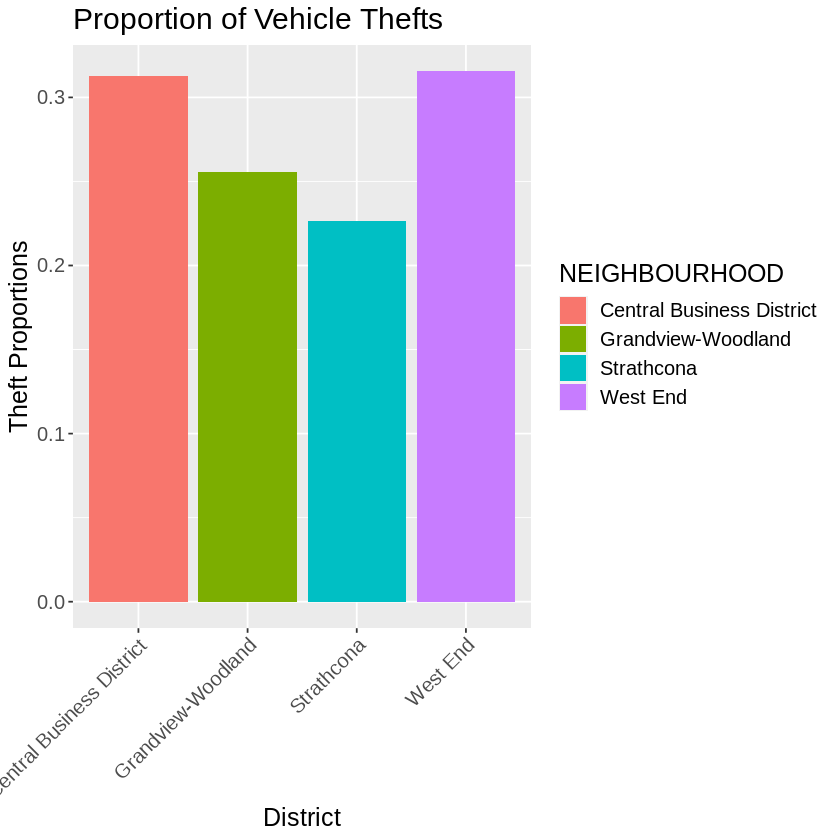

In [17]:
prop_theft_plot <- crime_theft_prop |>
    ggplot(aes(x = NEIGHBOURHOOD, y = prop, fill = NEIGHBOURHOOD)) +
    geom_bar(stat = "identity") +
    labs(title = "Proportion of Vehicle Thefts", x = "District", y = "Theft Proportions") +
    theme(text = element_text(size = 15), axis.text.x = element_text(angle = 45,hjust=1))
prop_theft_plot

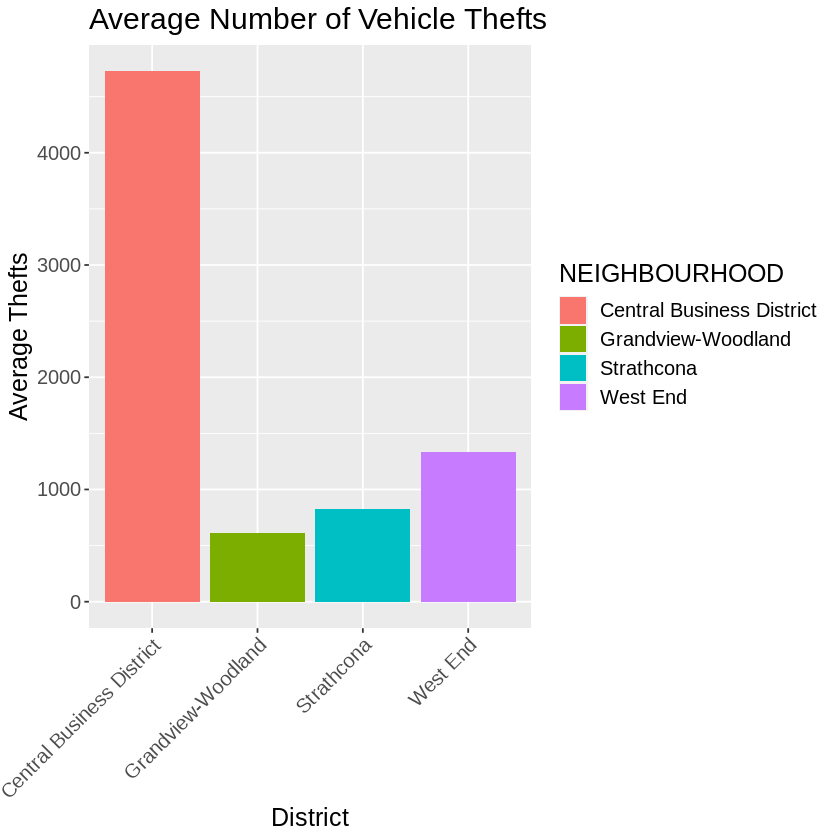

In [18]:
mean_theft_plot <- crime_theft_ave |>
    ggplot(aes(x = NEIGHBOURHOOD, y = mean_theft, fill = NEIGHBOURHOOD)) +
    geom_bar(stat = "identity") +
    labs(title = "Average Number of Vehicle Thefts", x = "District", y = "Average Thefts") +
    theme(text = element_text(size = 15), axis.text.x = element_text(angle = 45,hjust=1))

mean_theft_plot

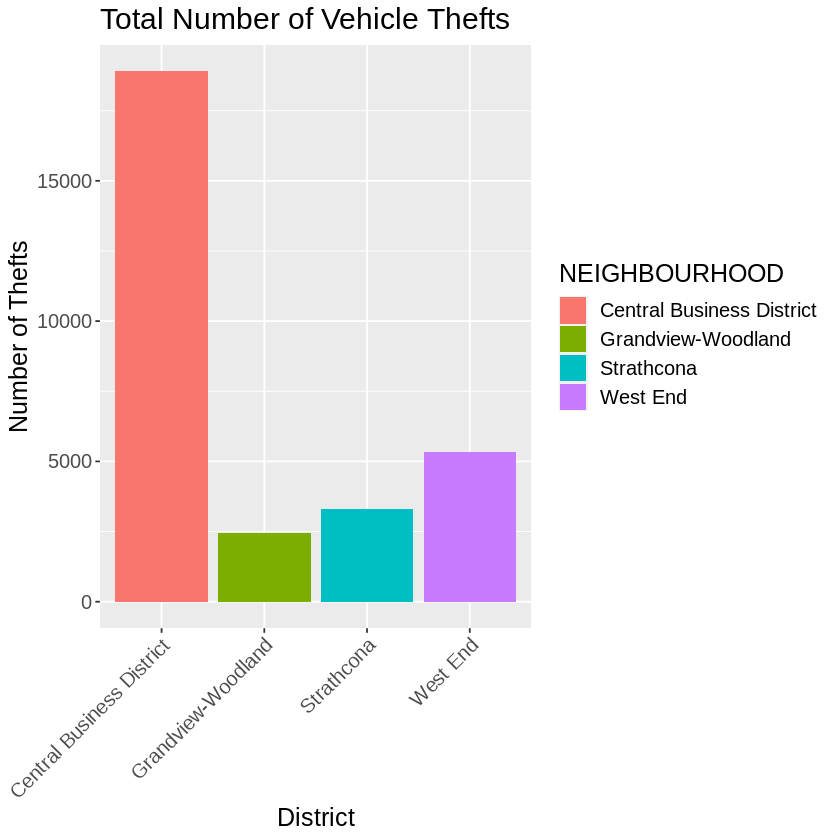

In [19]:
all_thefts_plot <- crime2s |>
    filter(TYPE == "Theft from Vehicle") |>
    group_by(NEIGHBOURHOOD) |>
    summarize(n = n()) |>
    ggplot(aes(x = NEIGHBOURHOOD, y = n, fill = NEIGHBOURHOOD)) +
    geom_bar(stat = "identity") +
    labs(title = "Total Number of Vehicle Thefts", x = "District", y = "Number of Thefts") +
    theme(text = element_text(size = 15), axis.text.x = element_text(angle = 45,hjust=1))
    
all_thefts_plot

##### Table of Estimates

# Methods: Plan

The above plots show the proportion of crimes that are vehicle thefts, the average number of vehicle thefts, and the total number of vehicle thefts for each of the 4 neighbourhoods using data from years 2018-2022. It is the raw, unbiased data for each area, which is helpful in gathering a general understanding of what to expect given the trends we can already see on numbers and proportions of vehicle thefts given the neighbourhood name.

The above analysis is simply raw data, and does not yet have enough analysis applied to be able to present the findings. In order to come to a viable conclusion, a hypothesis test must be carried out to determine whether one area group has a significantly higher proportion of vehicle thefts than the other.

$H_{o}$ : The proportion of thefts from vehicles in the Strathcona and Grandview-Woodland districts **is not significantly lower** than in the West End and Central Business districts of Vancouver, BC, between 2018 to 2022.

$H_{a}$ :  The proportion of thefts from vehicles in the Strathcona and Grandview-Woodland districts **is significantly lower** than in the West End and Central Business districts of Vancouver, BC, between 2018 to 2022.

A **confidence** interval for the true proportion of vehicle thefts in each area group will be constructed via bootstrapping from the samples. The data disclaimer indicates that these numbers given do not represent all issues brought up to the VPD, so using a bootstrapping method would prevent any overestimation of precision that could lead to a unrealistically narrow confidence interval.

##### What do you expect to find?

We expect to find that areas locally known as "nicer" areas will have lower numbers of vehicle thefts, such as the West End, compared to neighbourhoods such as Strathcona. We also expect that the results given by numbers will differ from the results given by proportions, as neighbourhoods are not all equal in size, population, wealth, and other factors that can impact vehicle theft rates.

 ##### What impact could such findings have?

Determining the areas where car thefts are can aid with deciding which areas should have more infastructure devoted to vehicle security. This could include measures such as having regular security workers in a particular parkade, adding security cameras in high-risk areas, or installing warning signs to alert citizens to not leave valuables in their car in a certain area.

##### What future questions could this lead to?

Once it is analyzed which areas are significantly more likely to have vehicle thefts, some other things to consider could be:

- How has the proportion and number of vehicle thefts change over the past 5, 10, and 15 years?
     - And does this correlate with any relevant environmental/social/political factors such as COVID-19, the increase of the opioid crisis in Downtown Vancouver, or increase in cost of living?
     
- Are there certain months, days, or times where vehicle thefts are at their highest?

- What vehicle type is most commonly stolen?

Overall, coming to a conclusion on vehicle theft rates and the factors behind them could assist with the prediction, prevention, and therefore lowering of total vehicle theft rates in an area.

# References

At least two citations of literature relevant to the project. The citation format is your choice – just be consistent. Make sure to cite the source of your data as well.

- 1
- 2
